In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set()

import sys
sys.path.append('..')
from stonks.DataCatcher import DB

In [2]:
dbase = DB()

In [3]:
data = dbase.fetch_last(3600 * 24, 'btcusdt')

In [5]:
from stonks.auxiliary.data_preprocessing import get_kline_info, get_state, plot_state

In [8]:
y = get_state(data, 0.003)

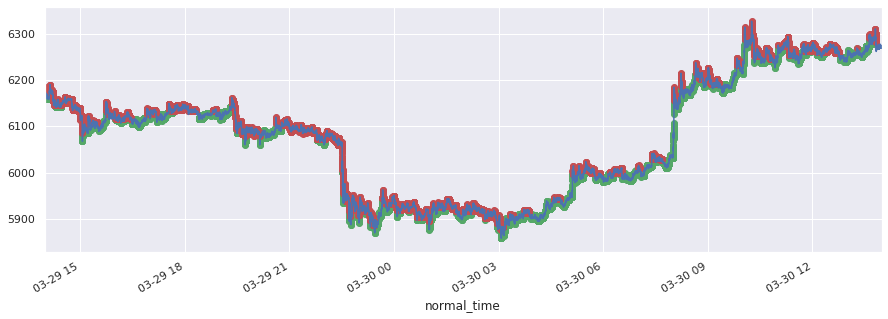

../stonks/auxiliary/data_preprocessing.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['normal_time'] = data['time'].apply(datetime.datetime.fromtimestamp)


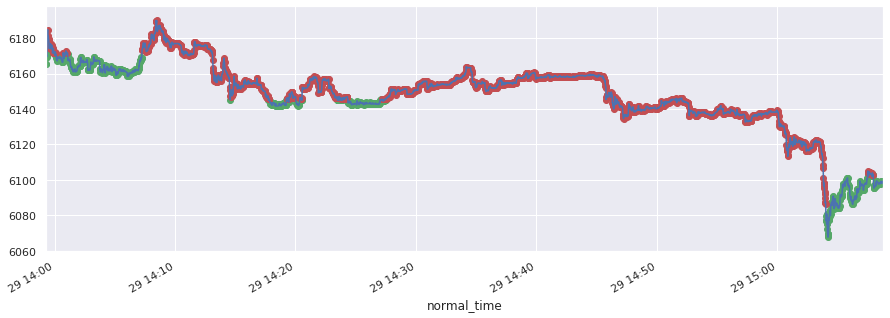

In [10]:
plt.figure(figsize=(15, 5))
plot_state(data, y)
plt.show()

plt.figure(figsize=(15, 5))
plot_state(data[:3600], y[:3600])

In [11]:
klines = get_kline_info(data)

/home/data_sapiens/Anaconda/lib/python3.7/site-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/home/data_sapiens/Anaconda/lib/python3.7/site-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [12]:
klines.set_index('normal_time', drop=True, inplace=True)

In [13]:
klines.drop(['time', 'id', 'currency_pair'], axis=1, inplace=True)

In [14]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def fit(X, y):
    model = LogisticRegression(n_jobs=-1, solver='lbfgs')
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(classification_report(y_test, pred))
    
    proba = model.predict_proba(X_test)
    probas = pd.DataFrame(proba, columns=['maximum', 'minimum'], index=X_test.index)
    
    return model, X_train, X_test, y_train, y_test, probas

In [25]:
from sklearn.model_selection import cross_val_score

In [27]:
cross_val_score( LogisticRegression(n_jobs=-1, solver='lbfgs'), klines, y)

/home/data_sapiens/Anaconda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.57258567, 0.53703011, 0.50965812])

In [20]:
y = get_state(klines, 0.003)

In [21]:
klines = klines[y != -1]
y = y[y != -1]

In [22]:
model, X_train, X_test, y_train, y_test, probas = fit(klines, y)

              precision    recall  f1-score   support

           0       0.36      0.52      0.42      5029
           1       0.66      0.50      0.57      9416

    accuracy                           0.51     14445
   macro avg       0.51      0.51      0.50     14445
weighted avg       0.56      0.51      0.52     14445



In [31]:
to_leave = [['depth_ask_price_' + str(i), 'depth_ask_quantity_' + str(i), 'depth_bid_price_' + str(i),
             'depth_bid_quantity_' + str(i)] for i in range(1, 21)]
lea = []
for el in to_leave:
    lea += el

In [32]:
klines.drop(lea, axis=1, inplace=True)

/home/data_sapiens/Anaconda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
def get_importances(model):
    imp = model.feature_importances_
    names = model.get_booster().feature_names
    li = list(zip(imp, names))
    li.sort(reverse=True)
    return li

In [19]:
get_importances(model)[:10]

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [23]:
def plot(X_test, y_test, probas):
    X_test1 = X_test[-3600:]
    probas1 = probas[-3600:]
    y_test1 = y_test[-3600:]
    
    X_test1['target'] = (X_test1['depth_bid_price_1'] + X_test1['depth_ask_price_1']) / 2.

    ups = probas1['maximum'] > 0.5
    downs = probas1['minimum'] > 0.5

    plt.figure(figsize=(15, 5))
    plt.plot(X_test1.index, X_test1['target'])
    plt.scatter(X_test1[y_test1 == 1].index, X_test1[y_test1== 1]['target'], color='g')
    plt.scatter(X_test1[y_test1 == 0].index, X_test1[y_test1 == 0]['target'], color='r')
    plt.show()
    plt.figure(figsize=(15, 5))
    plt.plot(X_test1.index, X_test1['target'])
    plt.scatter(X_test1[ups].index, X_test1[ups]['target'], color='r')
    plt.scatter(X_test1[downs].index, X_test1[downs]['target'], color='g')

/home/data_sapiens/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


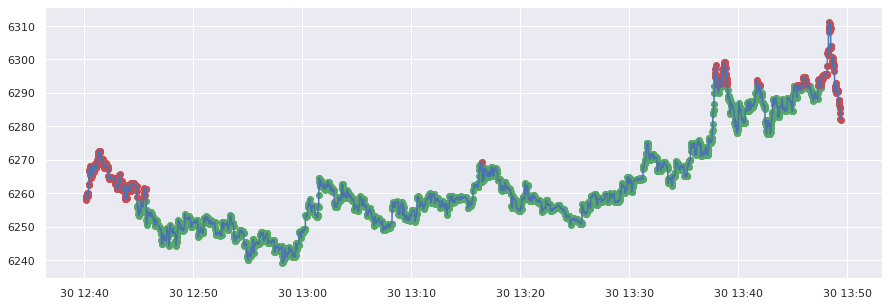

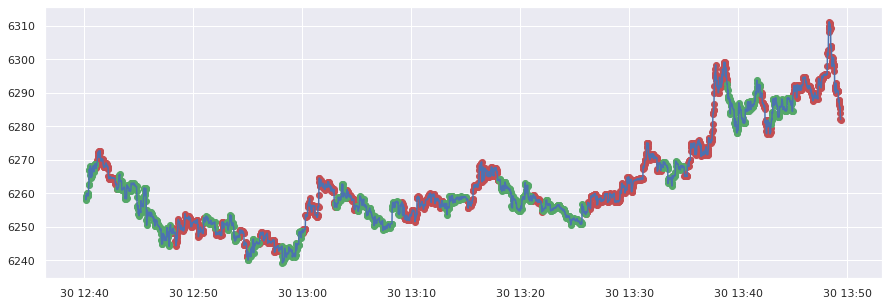

In [24]:
plot(X_test, y_test, probas)

In [29]:
data

id          time currency_pair  depth_bid_price_1  \
38     19393420  1.585480e+09       btcusdt            6171.02   
39     19393431  1.585480e+09       btcusdt            6169.35   
40     19393442  1.585480e+09       btcusdt            6172.29   
41     19393453  1.585480e+09       btcusdt            6171.43   
42     19393464  1.585480e+09       btcusdt            6170.00   
...         ...           ...           ...                ...   
75385  20222245  1.585566e+09       btcusdt            6271.56   
75386  20222256  1.585566e+09       btcusdt            6270.03   
75387  20222267  1.585566e+09       btcusdt            6269.46   
75388  20222278  1.585566e+09       btcusdt            6268.54   
75389  20222289  1.585566e+09       btcusdt            6268.61   

       depth_bid_price_2  depth_bid_price_3  depth_bid_price_4  \
38               6169.66            6169.63            6169.35   
39               6169.27            6169.26            6169.11   
40               6171.37            6171.33            6171.15   
41               6171.15            6171.09            6169.89   
42               6169.90            6169.81            6169.72   
...                  ...                ...                ...   
75385            6271.45            6271.11            6270.66   
75386            6270.02            6269.40            6269.37   
75387            6269.45            6269.37            6269.00   
75388            6268.50            6268.09            6268.06   
75389            6268.60            6268.51            6268.50   

       depth_bid_price_5  depth_bid_price_6  depth_bid_price_7  ...  \
38               6169.26            6169.09            6168.86  ...   
39               6169.10            6169.09            6168.86  ...   
40               6171.09            6170.74            6170.71  ...   
41               6169.74            6169.71            6169.29  ...   
42               6168.86            6168.67            6168.66  ...   
...                  ...                ...                ...  ...   
75385            6270.65            6270.64            6270.55  ...   
75386            6269.04            6269.00            6268.97  ...   
75387            6268.37            6268.32            6268.31  ...   
75388            6268.00            6267.51            6267.16  ...   
75389            6268.04            6268.00            6267.51  ...   

       depth_ask_quantity_13  depth_ask_quantity_14  depth_ask_quantity_15  \
38                  0.243080               0.200000               0.039355   
39                  0.300000               0.003000               0.543050   
40                  0.200000               0.343570               0.323839   
41                  0.009000               0.411216               0.309000   
42                  0.162059               0.162032               0.009000   
...                      ...                    ...                    ...   
75385               0.119402               0.400000               0.400000   
75386               0.500000               0.500043               0.500000   
75387               0.300202               0.309066               0.309000   
75388               0.500000               0.289838               0.200000   
75389               0.200000               0.159515               0.104720   

       depth_ask_quantity_16  depth_ask_quantity_17  depth_ask_quantity_18  \
38                  0.300000               0.543078               0.543050   
39                  6.200000               0.009000               0.108380   
40                  0.019677               0.300000               1.385907   
41                  0.102180               0.425698               0.162034   
42                  0.300000               0.309000               0.102180   
...                      ...                    ...                    ...   
75385               0.300000               0.400000               0.159459   
75386        